- [👀 코드 기반 답변하는 💻 GitHub 소스코드 기반 Q&A 챗봇🤖 제작기](https://youtu.be/yB8b-lW_5HY)
- [노코딩으로 쇼핑몰 리뷰 분석 (크롤링 + Q&A 챗봇)](https://youtu.be/r5YyftofuII)
- [RAG 파이프라인 이해해보기 - 네이버 뉴스기사 기반 Q&A 챗봇 제작](https://youtu.be/1scMJH93v0M)
- [LangChain Expression Language(LCEL) 원리 이해와 파이프라인 구축 가이드](https://teddylee777.github.io/langchain/langchain-lcel/)
- [네이버 뉴스 기반 Q&A 애플리케이션 구축하기 - 기본편](https://teddylee777.github.io/langchain/rag-naver-news-qa/)
- [RAG 파헤치기: 문서 기반 QA 시스템 설계 방법 - 심화편](https://teddylee777.github.io/langchain/rag-tutorial/)
- [에이전트(Agent)와 도구(tools)를 활용한 지능형 검색 시스템 구축 가이드](https://teddylee777.github.io/langchain/langchain-agent/)

# GitHub 소스코드 기반 Q&A 챗봇

랭그래프 리포지토리를 적당한 폴더에 클론합니다.

```sh
git clone https://github.com/langchain-ai/langgraph
```

In [1]:
%pip install -qU unstructured langchain_text_splitters langchain-community langchain_cohere faiss-cpu 

/Users/anpigon/Workspace/Wantedlab/langchain-academy/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


## 환경변수

In [2]:
from dotenv import load_dotenv

load_dotenv("../../.env", override=True)

True

In [3]:
import os
import getpass


def _set_env(var: str):
    env_value = os.environ.get(var)
    if not env_value:
        env_value = getpass.getpass(f"{var}: ")

    os.environ[var] = env_value


_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "01-Github-Code-QA-RAG"
_set_env("OPENAI_API_KEY")

## 데이터 전처리

먼저, 다운로드 받은 langgraph의 GitHub 저장소에서 파일을 로드합니다.

여기서 로드하는 파일은 파이썬 파일(.py), 마크다운 파일(.md), 노트북 파일(.ipynb)입니다.

In [4]:
ROOT_PATH = "../../langgraph"

libs_path = os.path.join(ROOT_PATH, "libs")
docs_path = os.path.join(ROOT_PATH, "docs")
examples_path = os.path.join(ROOT_PATH, "examples")

all_repos = [libs_path, docs_path, examples_path]

## 문서 로더

In [5]:
from langchain_core.documents import Document
from langchain_community.document_loaders import (
    DirectoryLoader,
    UnstructuredMarkdownLoader,
    NotebookLoader,
)
from langchain_community.document_loaders.generic import GenericLoader
from langchain_community.document_loaders.parsers import LanguageParser


# 파이썬 파일 로더
def load_python_files(paths: list[str]) -> list[Document]:
    documents: list[Document] = []

    for path in paths:
        loader = GenericLoader.from_filesystem(
            path,
            glob="**/[!.]*",
            suffixes=[".py"],
            show_progress=True,
            parser=LanguageParser(language="python", parser_threshold=30),
        )
        documents.extend(loader.load())

    return documents


# 마크다운 파일 로더
def load_markdown_files(paths: list[str]) -> list[Document]:
    documents: list[Document] = []

    for path in paths:
        try:
            loader = DirectoryLoader(
                path,
                glob="**/*.md",
                loader_cls=UnstructuredMarkdownLoader,
                loader_kwargs={"mode": "single"},
                recursive=True,
            )
            documents.extend(loader.load())
        except Exception as e:
            print(f"Error loading Markdown files from {path}: {str(e)}")
            continue

    return documents


# 주피터 노트북 파일 로더
def load_notebook_files(paths: list[str]) -> list[Document]:
    documents: list[Document] = []

    exclude_dirs = [
        ".git",
        "__pycache__",
        ".ipynb_checkpoints",
        "node_modules",
        ".venv",
        "venv",
    ]
    notebook_files = []
    for path in paths:
        for root, dirs, files in os.walk(path):
            # 제외할 디렉토리 필터링
            dirs[:] = [d for d in dirs if d not in exclude_dirs]

            # .ipynb 파일 찾기
            for file in files:
                if file.endswith(".ipynb"):
                    full_path = os.path.join(root, file)
                    notebook_files.append(full_path)
    for file in notebook_files:
        loader = NotebookLoader(
            file,
            include_outputs=False,
            max_output_length=10,
            remove_newline=True,
            traceback=False,
        )
        documents.extend(loader.load())

    return documents

In [6]:
python_documents = load_python_files(all_repos)
print(len(python_documents))

/Users/anpigon/Workspace/Wantedlab/langchain-academy/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 64%|██████▎   | 149/234 [00:00<00:00, 228.05it/s]<unknown>:39: SyntaxWarning: invalid escape sequence '\('
<unknown>:39: SyntaxWarning: invalid escape sequence '\('
<unknown>:39: SyntaxWarning: invalid escape sequence '\('
100%|██████████| 1/1 [00:00<00:00, 344.84it/s]

1894


In [7]:
markdown_documents = load_markdown_files(all_repos)
print(len(markdown_documents))

174


In [8]:
notebook_documents = load_notebook_files(all_repos)
print(len(notebook_documents))

111


In [9]:
all_docs = python_documents + markdown_documents + notebook_documents
print(len(all_docs))

2179


## 문서 분할

In [10]:
from langchain_text_splitters import (
    PythonCodeTextSplitter,
    MarkdownTextSplitter,
    RecursiveCharacterTextSplitter,
    Language,
)

# 파이썬 코드 스플릿터
python_splitter = PythonCodeTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
)

# 마크다운 스플릿터
markdown_splitter = MarkdownTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
)


# 주피터 노트북 스필릿터
notebook_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    separators=RecursiveCharacterTextSplitter.get_separators_for_language(
        Language.PYTHON
    )
    + RecursiveCharacterTextSplitter.get_separators_for_language(Language.MARKDOWN),
    length_function=len,
)

In [11]:
# 파이썬 문서 분할
splited_python_documents = python_splitter.split_documents(python_documents)
len(splited_python_documents)

5681

In [12]:
# 마크다운 문서 분할
splited_markdown_documents = markdown_splitter.split_documents(markdown_documents)
len(splited_markdown_documents)

2377

In [13]:
# 주피터 노트북 문서 분할
splited_notebook_documents = notebook_splitter.split_documents(notebook_documents)
len(splited_notebook_documents)

1261

In [14]:
all_splited_documents = (
    splited_python_documents + splited_markdown_documents + splited_python_documents
)
len(all_splited_documents)

13739

## 임베딩 및 벡터 DB에 저장

[`CacheBackedEmbeddings`](https://python.langchain.com/docs/how_to/caching_embeddings/)을 사용하면 임베딩을 다시 계산할 필요없이 일시적으로 캐시할 수 있습니다.

[`FAISS`](https://python.langchain.com/docs/integrations/vectorstores/faiss/#manage-vector-store)는 효율적인 유사성 검색 및 밀집 벡터 클러스터링을 위한 라이브러리입니다.

### 임베딩 모델 생성 및 임베딩 캐시

In [15]:
from langchain.storage import LocalFileStore
from langchain_openai import OpenAIEmbeddings
from langchain.embeddings import CacheBackedEmbeddings


# 임베딩 모델 생성
underlying_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

store = LocalFileStore("./cache")

embeddings = CacheBackedEmbeddings.from_bytes_store(
    underlying_embeddings,
    store,
    namespace=underlying_embeddings.model,
    query_embedding_cache=True,
)

/Users/anpigon/Workspace/Wantedlab/langchain-academy/.venv/lib/python3.12/site-packages/langchain/embeddings/cache.py:58: UserWarning: Using default key encoder: SHA-1 is *not* collision-resistant. While acceptable for most cache scenarios, a motivated attacker can craft two different payloads that map to the same cache key. If that risk matters in your environment, supply a stronger encoder (e.g. SHA-256 or BLAKE2) via the `key_encoder` argument. If you change the key encoder, consider also creating a new cache, to avoid (the potential for) collisions with existing keys.
  _warn_about_sha1_encoder()


In [16]:
# 임베딩하기 전에 캐시가 비어 있습니다.
list(store.yield_keys())

['text-embedding-3-smallefab7c41-f7ca-59d0-ae4d-a4128a978e9e',
 'text-embedding-3-smallbebb2b07-d1c9-5b46-be55-d59945329f8f',
 'text-embedding-3-small4915f093-a9dd-58d9-9cdf-3e51ffec3ac6',
 'text-embedding-3-smallf80ccbba-8bd5-5539-af45-4e43804ed561',
 'text-embedding-3-smallf73cdfef-9283-503e-944e-81c5970be50c',
 'text-embedding-3-small46f63026-53a1-544c-8673-7ca5251a6cc2',
 'text-embedding-3-small2bd064ae-bf91-5fe3-9427-5d2ae715ccfa',
 'text-embedding-3-small5fde2c48-009d-5d7a-a980-fc49ce1af250',
 'text-embedding-3-small33c9d5b6-8acf-53a8-8cd6-e0910aad84f1',
 'text-embedding-3-smalldeff0122-84e2-57eb-bc4c-d9eddf61354b',
 'text-embedding-3-small5152fe27-793b-5156-9f00-df084d8c4870',
 'text-embedding-3-small5beb777a-b97e-513a-b23b-9d00bbfaa3d2',
 'text-embedding-3-small22d50595-a5e1-5342-9c2f-8ffa5517de71',
 'text-embedding-3-smallb4dc4307-0d6f-5a7f-8282-9a7dd582442e',
 'text-embedding-3-small0317a197-14bb-5432-a5f6-c083ccc0a4d2',
 'text-embedding-3-small1a0a55ad-0776-5bf0-af74-53d5843

### 벡터 저장소 초기화

In [17]:
# 벡터 스토어 생성
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS

index = faiss.IndexFlatL2(len(embeddings.embed_query("hello")))

vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

### 문서를 벡터 저장소에 추가

In [18]:
results = vector_store.add_documents(documents=all_splited_documents)
results[:5]

['0e93a970-2a9f-42df-840f-e993d08ab152',
 '5ef48fc5-d060-4eaf-a96c-26489dbbda5f',
 '2e54b739-73d2-4710-af81-10e6eb0924ec',
 '790c5a7e-59ae-400f-949b-218ccfb0f9b2',
 '3f1e2c01-e15b-4ced-9a86-87f63dd0d96c']

### 벡터 스토어 저장 및 불러오기

FAISS 인덱스를 저장하고 불러올 수도 있습니다. 이렇게 하면 매번 사용할 때마다 새로 생성할 필요가 없어서 편리합니다.

In [19]:
# 벡터 스토어를 저장하고 불러오기
vector_store.save_local("faiss_index")

new_vector_store = FAISS.load_local(
    "faiss_index",
    embeddings,
    allow_dangerous_deserialization=True,
)

In [20]:
docs = new_vector_store.similarity_search("self-rag")
print(docs[0].page_content)

def _strip_self(sig: inspect.Signature) -> inspect.Signature:
    params = list(sig.parameters.values())
    if params and params[0].name == "self":
        params = params[1:]
    return sig.replace(parameters=params)


## RAG 체인 구축

여기서는 Naive RAG를 구성합니다. 그리고 검색 정확도를 향상시키기 위해 [Cohere Rerank](https://python.langchain.com/api_reference/langchain/retrievers/langchain.retrievers.document_compressors.cohere_rerank.CohereRerank.html#coherererank)를 사용합니다.

In [21]:
retriever = vector_store.as_retriever(search_kwargs={"k": 200})

In [22]:
retriever.invoke("self-rag")[:5]

[Document(id='3d70aeb9-c402-4f2b-9b10-2930058419ed', metadata={'source': '../../langgraph/libs/sdk-py/tests/test_api_parity.py', 'content_type': 'functions_classes', 'language': 'python'}, page_content='def _strip_self(sig: inspect.Signature) -> inspect.Signature:\n    params = list(sig.parameters.values())\n    if params and params[0].name == "self":\n        params = params[1:]\n    return sig.replace(parameters=params)'),
 Document(id='d5bba9b5-6b90-4ecf-8796-73c63f7d9d53', metadata={'source': '../../langgraph/libs/sdk-py/tests/test_api_parity.py', 'content_type': 'functions_classes', 'language': 'python'}, page_content='def _strip_self(sig: inspect.Signature) -> inspect.Signature:\n    params = list(sig.parameters.values())\n    if params and params[0].name == "self":\n        params = params[1:]\n    return sig.replace(parameters=params)'),
 Document(id='1837a9df-f44b-4b54-9e00-ffb17272c99d', metadata={'source': '../../langgraph/libs/checkpoint/langgraph/store/base/batch.py', 'con

In [23]:
# Reranker 설정
from langchain_cohere import CohereRerank
from langchain.retrievers import ContextualCompressionRetriever

compressor = CohereRerank(model="rerank-v3.5", top_n=20)
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=retriever,
)

In [24]:
# prompt 설정
system_prompt = """당신은 CODE Copilot 어시스턴트입니다. 
질문에 답변하기 위해 다음에 제시된 소스 코드 또는 문서의 일부를 반드시 사용해야 합니다.
RAG(Retrieval Augmented Generation) 소스 코드 및 문서와 관련된 질문이 주어집니다.
답변을 모르는 경우에는 모른다고 말하십시오. 
답변은 한국어로 작성하십시오.

질문에 답변할 때 다음 지침을 따르십시오:

1. 제공된 CONTEXT 내의 정보만 사용하십시오. 
2. 가능한 한 많은 예제 코드 조각을 포함하십시오.
3. 전체 코드 조각을 작성하는 것을 매우 권장합니다.
4. CONTEXT에 명시적으로 언급된 내용을 넘어 외부 정보를 도입하거나 추측하지 마십시오.
5. CONTEXT에는 각 개별 문서의 주제별 출처가 포함되어 있습니다.
6. 답변 내 관련 진술 옆에 해당 출처를 포함하십시오. 예를 들어 출처 #1의 경우 [1]을 사용하십시오. 
7. 답변 하단에 출처를 순서대로 나열하십시오. [1] 출처 1, [2] 출처 2, 등
8. 출처가 <source>assistant/docs/llama3_1.md" page="7"</source>인 경우 다음과 같이 나열하십시오: [1] llama3_1.md
        
인용 시 괄호 추가 및 문서 출처 서두 문구를 생략하십시오.

----

### 출처

출처 섹션에서는:
- 답변에 사용된 모든 출처를 포함하십시오
- 관련 웹사이트 또는 문서 이름에 대한 전체 링크를 제공하십시오
- 각 출처는 새 줄로 구분하십시오. 마크다운에서 새 줄을 생성하려면 각 줄 끝에 공백 두 개를 사용하십시오.
- 다음과 같이 표시됩니다:

**출처**
- [1] 링크 또는 문서명
- [2] 링크 또는 문서명

출처를 반드시 통합하세요. 예를 들어 다음은 올바르지 않습니다:

- [3] https://ai.meta.com/blog/meta-llama-3-1/
- [4] https://ai.meta.com/blog/meta-llama-3-1/

중복 출처는 없어야 합니다. 다음과 같이 간결하게 작성하세요:

- [3] https://ai.meta.com/blog/meta-llama-3-1/

-----

### CONTEXT

질문에 답변할 때 사용할 수 있는 CONTEXT 입니다:

{context}

----

### 질문

사용자의 질문은 다음과 같습니다:

{question}

----

최종 검토 사항:
- 보고서가 요구되는 구조를 따르고 있는지 확인하세요
- 모든 가이드라인이 준수되었는지 확인하세요
- 해당되는 경우 답변에 전체 코드 스니펫이 포함되었는지 확인하세요
- 답변은 한국어로 작성되어야 합니다
- 많은 예제 코드 스니펫을 사용하면 사용자로부터 높은 평가를 받을 수 있습니다
- 단계별로 생각하세요.

----

질문에 대한 답변과 출처:"""

In [ ]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

template = ChatPromptTemplate(
    [
        ("system", system_prompt),
        ("user", "{user_input}"),
    ]
)

llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

chain = (
    {
        "user_input": itemgetter("input"),
        "context": itemgetter("context"),
    }
    | template
    | llm
    | StrOutputParser()
)

## LangGraph 구성하기

### 상태 정의

In [ ]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]
    question: Annotated[str, "question"]
    documents: Annotated[list[str], "documents"]

### Routing 노드

사용자 질문의 의도를 파악하고 routing를 수행합니다.
벡터 검색이 필요한지 아닌지 여부만 판단합니다.

In [167]:
from typing import Literal
from pydantic import BaseModel, Field


class RouteQuery(BaseModel):
    binary_score: Annotated[
        Literal[1, 0],
        Field(
            ...,
            description="사용자 질문이 벡터 스토어 검색이 필요한지 여부를 판단합니다."
            "벡터 스토어에는 LangGraph 와 RAG(Retrieval Augmented Generation) 관련 소스 코드와 문서가 포함되어 있습니다."
            "관련 있는 경우는 1를 반환합니다."
            "질문이 소스 코드 또는 문서와 관련된지 판단할 수 없는 경우 1을 반환하십시오."
            "답변을 모르는 경우 1를 반환하십시오."
            "그 외에는 모두 0을 반환합니다.",
        ),
    ]


# 라우팅 노드
def routing_node(state):
    routing_llm = llm.with_structured_output(RouteQuery)

    response = routing_llm.invoke([state["messages"][-1]])

    if response.binary_score == 1:
        return "query_expansion"
    else:
        return "general_answer"

In [168]:
routing_node({"messages": [("user", "self-rag에 대해서 설명해주세요")]})

'query_expansion'

In [169]:
routing_node({"messages": [("user", "오늘 날씨는?")]})

'general_answer'

### 질문 재작성 노드

In [ ]:
from pydoc import describe
from langchain_core.messages import HumanMessage


class RewriteQuery(BaseModel):
    question: Annotated[
        str,
        Field(
            ...,
            description="질문 재작성 도구로, 입력된 질문을 CODE SEARCH(github repository)에 최적화된 더 나은 버전으로 변환합니다."
            "기존 질문의 근본적인 의미적 의도/의미를 추론하세요."
            "영어로 작성하세요.",
        ),
    ]


def rewrite_query_node(state: State):
    question = state.get("question") if state.get("question") else state["messages"][-1]

    rewriter_llm = llm.with_structured_output(RewriteQuery)

    if isinstance(question, str):
        response = rewriter_llm.invoke([HumanMessage(content=question)])
    else:
        response = rewriter_llm.invoke([question])

    return {"question": response.question}

In [184]:
rewrite_query_node({"messages": [("user", "self-rag?")]})

{'question': "Could you please provide a detailed explanation of 'self-rag'? Additionally, if possible, include related concepts or methods to better understand its context and applications."}

### 평가 노드

문서의 관련성 여부와 환각 여부를 평가합니다.
1. 검색된 문서의 관련성 평가
2. 답변의 환각 여부 평가
3. 답변 질문에 대한 관련성 평가

In [ ]:
# 문서 평가를 위한 데이터 모델 정의
class GradeDocuments(BaseModel):
    """검색된 문서의 관련성 검증"""

    binary_score: Annotated[
        Literal[1, 0],
        Field(
            ..., description="Context 문서가 질문과 관련이 있는가? 1 또는 0 으로 답변"
        ),
    ]


# 문서 관련성 평가 노드
def filtering_documents_node(state: State):
    question = state.get("question")
    documents = state.get("documents")

    grader_llm = llm.with_structured_output(GradeDocuments)

    filtered_docs = []
    for doc in documents:
        response = grader_llm.invoke(f"{question}\n\n{doc}")
        if response.binary_score == 1:
            filtered_docs.append(doc)
        continue

    return {"documents": filtered_docs}

### 벡터 스토어 검색 노드

In [ ]:
def retrieve_node(state: State):
    question = state.get("question")

    documents = compression_retriever.invoke(question)
    return {"documents": documents}

In [ ]:
retrieve_node({"question": "self-rag에 대해서 설명해주세요."})

{'documents': [Document(metadata={'source': '../../langgraph/libs/cli/js-examples/README.md', 'relevance_score': 0.12906231}, page_content='Add retrieval-augmented generation (RAG) capabilities by integrating external APIs or databases to provide more customized responses.\n\nDevelopment\n\nWhile iterating on your graph, you can edit past state and rerun your app from previous states to debug specific nodes. Local changes will be automatically applied via hot reload. Try experimenting with:\n\nModifying the system prompt to give your chatbot a unique personality.\n\nAdding new nodes to the graph for more complex conversation flows.\n\nImplementing conditional logic to handle different types of user inputs.\n\nFollow-up requests will be appended to the same thread. You can create an entirely new thread, clearing previous history, using the + button in the top right.\n\nFor more advanced features and examples, refer to the LangGraph.js documentation. These resources can help you adapt th

### 웹 검색 노드

In [ ]:
from langchain_tavily import TavilySearch

search_tool = TavilySearch(max_results=3)


def web_search(state: State):
    question = state.get("question")

    web_results = search_tool.invoke(question)

    documents: list[Document] = []
    for r in web_results["results"]:
        documents.append(
            Document(
                page_content=f"# {r['title']}\n\n{r['content']}",
                metadata={
                    "source": r["url"],
                    "score": r["score"],
                },
            )
        )

    return {"documents": documents}

In [ ]:
web_search({"question": "대한민국의 수도는?"})

{'documents': [Document(metadata={'source': 'https://quizlet.com/kr/591770273/lesson-2-대한민국의-수도는-서울입니다-flash-cards/', 'score': 0.8997663}, page_content='# Lesson 2: 대한민국의 수도는 서울입니다 낱말 카드\n\n대한민국의 수도는서울입니다. 서울은 한반도의 중심에 있고 인구는 약천만 명입니다. 서울에는 구경할 곳이 많습니다. 먼저 외국인들이 많이 찾아가는 남산이'),
  Document(metadata={'source': 'https://namu.wiki/w/수도(도시)', 'score': 0.86981434}, page_content='# 수도(도시)\n\n6 days ago—대한민국은 조선과 대한제국의 수도 한성이 이어진서울특별시를 계속 수도로 설정하고 있다. 일제강점기에도 행정중심지인 조선총독부가 서울(경성)에'),
  Document(metadata={'source': 'https://m.kin.naver.com/qna/dirs/111001/docs/478501757?d1id=11', 'score': 0.8622012}, page_content='# 대한민국 수도 서울\n\n대한민국 수도 서울 대한민국의 수도인 서울이 어떻게 수도가 됐는지가 궁금합니다. 서울이 조선시대 때 한양이라 불리우며 조선의 수도였던 것은 아는데 그 조선의 수도가 자연스레 한국의 수도가 되어 대한민국의 수도는 서울이다라는 공식 선언같은 건 없이 지금의 대한민국의 수도가 되었다는 말도 있던데 그게 사실인가요?? #문제풀이 우리나라 수도 명칭인 서울은 원래 한 나라의 수도를 뜻하는 순수한 우리말의 일반명사였어요. 그래서 신라의 수도였던 서라벌, 고려의 수도였던 개성도 모두 서울이라고 불렀지요. 조선의 수도였던 한양 역시 사람들은 대부분 지금처럼 서울이라고 불렀어요. 그러다가 서울이 우리나라의 수도이자 지명을 겸하는 제도상 공식명칭으로 쓰이기 시작한 것은   그

### 백터 스토어 기반 답변 생성 노드

In [ ]:
def answer_rag_node(state: State):
    question = state.get("question")
    documents = state.get("documents")

    response = llm.invoke(
        system_prompt.format(
            context=documents,
            question=question,
        )
    )

    return {
        "messages": [response],
        "generation": response.content,
    }

In [ ]:
answer_rag_node(
    {
        "question": "대한민국 수도는?",
        "documents": [Document(page_content="서울")],
    },
)

{'messages': [AIMessage(content='대한민국의 수도는 "서울"입니다.  \n\n예를 들어, 다음과 같이 간단한 파이썬 코드로 수도를 출력할 수 있습니다:\n\n```python\ncapital = "서울"\nprint("대한민국의 수도는", capital, "입니다.")\n```\n\n출력 결과:\n```\n대한민국의 수도는 서울 입니다.\n```\n\n또한, 만약 데이터베이스나 문서에서 수도 정보를 조회하는 경우, 다음과 같이 사용할 수 있습니다:\n\n```python\n# 수도 정보가 저장된 변수\ncountry_capital = {\n    "대한민국": "서울",\n    "일본": "도쿄",\n    "중국": "베이징"\n}\n\nprint("대한민국의 수도는", country_capital["대한민국"], "입니다.")\n```\n\n출력 결과:\n```\n대한민국의 수도는 서울 입니다.\n```\n\n이처럼 "서울"이라는 정보는 CONTEXT 내에 명확히 포함되어 있습니다.\n\n**출처**  \n- [1] 서울', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 208, 'prompt_tokens': 689, 'total_tokens': 897, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_95d112f245', 'id': 'chatcmpl-CN00vr6o2L7JC7V

### 일반적인 답변 생성 노드

In [ ]:
def answer_general_node(state: State):
    response = llm.invoke(state["messages"])
    return {"messages": [response]}

In [ ]:
# 웹검색이 필요한지 여부 검사
def decide_to_web_search_node(state):
    filtered_docs = state["documents"]

    if len(filtered_docs) < 2:
        return "web_search"
    else:
        return "rag_answer"

In [ ]:
class GroundednessChecker(BaseModel):
    binary_score: Annotated[
        Literal[1, 0],
        Field(
            ...,
            description="LLM 답변이 검색된 사실 집합에 근거하거나 이를 뒷받침하는지 평가하는 채점 도구입니다."
            "답변이 사실 집합에 근거하거나 이를 뒷받침하면 1을 반환하고, 그렇지 않으면 0을 반환하세요.",
        ),
    ]


class RelevantAnswerChecker(BaseModel):
    binary_score: Annotated[
        Literal[1, 0],
        Field(
            ...,
            description="답변이 질문을 해결했는지 평가하는 채점 도구입니다."
            "질문에 대한 답변이 해결되었다면 1을 반환하고, 그렇지 않다면 0을 반환하세요.",
        ),
    ]


# 답변의 환각 여부/관련성 여부 평가 노드
def answer_groundedness_check(state):
    # 질문과 문서 검색 결과 가져오기
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    groundedness_checker = llm.with_structured_output(GroundednessChecker)
    relevant_answer_checker = llm.with_structured_output(RelevantAnswerChecker)

    # Groundedness 평가
    score = groundedness_checker.invoke(
        f"Set of facts: \n\n {documents} \n\n LLM generation: {generation}"
    )
    grade = score.binary_score

    # Groundedness 평가 결과에 따른 처리
    if grade == 1:
        # 답변의 관련성(Relevance) 평가
        score = relevant_answer_checker.invoke(
            f"User question: \n\n {question} \n\n LLM generation: {generation}"
        )
        grade = score.binary_score

        # 관련성 평가 결과에 따른 처리
        if grade == 1:
            return "relevant"
        else:
            return "not relevant"

    else:
        return "not grounded"

## 그래프 구성

In [185]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import InMemorySaver

builder = StateGraph(State)

# 노드
builder.add_node("query_expansion", rewrite_query_node)
builder.add_node("query_rewrite", rewrite_query_node)
builder.add_node("web_search", web_search)
builder.add_node("retrieve", retrieve_node)
builder.add_node("grade_documents", filtering_documents_node)
builder.add_node("general_answer", answer_general_node)
builder.add_node("rag_answer", answer_rag_node)

# 엣지
builder.set_conditional_entry_point(
    routing_node,
    {
        "query_expansion": "query_expansion",
        "general_answer": "general_answer",
    },
)
builder.add_edge("query_expansion", "retrieve")
builder.add_edge("retrieve", "grade_documents")
builder.add_conditional_edges(
    "grade_documents",
    decide_to_web_search_node,
    {
        "web_search": "web_search",
        "rag_answer": "rag_answer",
    },
)
builder.add_edge("query_rewrite", "rag_answer")
builder.add_conditional_edges(
    "rag_answer",
    answer_groundedness_check,
    {
        "relevant": END,
        "not relevant": "web_search",
        "not grounded": "query_rewrite",
    },
)

graph = builder.compile(checkpointer=InMemorySaver())

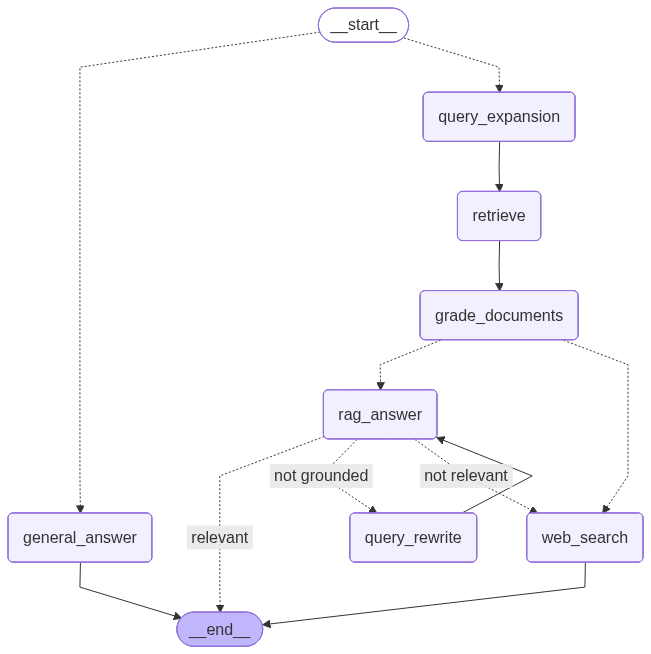

In [186]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

## 그래프 실행

In [ ]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    recursion_limit=20,
    configurable={"thread_id": "2"},
)

query = "Self-RAG 에서 사용되는 관련성 평가 노드 예제를 찾아주세요."
for event in graph.stream(
    {"messages": [HumanMessage(content=query)]},
    stream_mode="updates",
    config=config,
):
    for key, value in event.items():
        print(f"==== {key} ===")
        if "messages" in value:
            value["messages"][-1].pretty_print()

==== query_expansion ===
==== retrieve ===
==== grade_documents ===
==== rag_answer ===
================================== Ai Message ==================================

Self-RAG에서 사용되는 관련성 평가 노드는 검색된 문서들이 실제로 질문에 적합한지를 판단하는 역할을 합니다. 즉, 단순히 키워드 매칭이 아니라 문서의 의미적 관련도(semantic relevance)를 평가하여, 더 정확하고 유의미한 정보를 선택하는 과정입니다. 이 과정은 Retrieval Augmented Generation에서 매우 중요하며, 관련성 평가는 문서의 내용이 질문 의도와 얼마나 일치하는지를 수치화하는 작업입니다.

기존 Self-RAG 관련성 평가 노드 예제는 다음과 같이 구성되어 있습니다:

```python
input = {
    "messages": convert_to_messages([
        {
            "role": "user",
            "content": "What does Lilian Weng say about types of reward hacking?",
        },
        {
            "role": "assistant",
            "content": "",
            "tool_calls": [
                {
                    "id": "1",
                    "name": "retrieve_blog_posts",
                    "args": {"query": "types of reward hacking"},
                }
            ],
        },
        {
            "role": "tool",
   